这篇文档是用来做segmentation的，因为faster r-cnn真的是train不动了。
<br>
那玩意我调了好几天，少说得有二十多个小时了，太乱了。
<br>
所以现在的策略是使用和楼类似的方法分割图片。所以这篇文档做的事情和楼做的重复性很高
<br>
不过lou的代码我有点看不懂，所以就自己写一遍吧 X﹏X

In [6]:
import cv2
import torch
import random
import numpy as np
from utils import *
from matplotlib import pyplot as plt
import time

dataset = SegDataset('IAM', 'val')

In [7]:
# utils
def show_img(img: torch.Tensor):
    img = img.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()

基本策略（草稿）：
先总结图片的像素分布，然后把图片二值化
然后把图片变模糊

index: 142


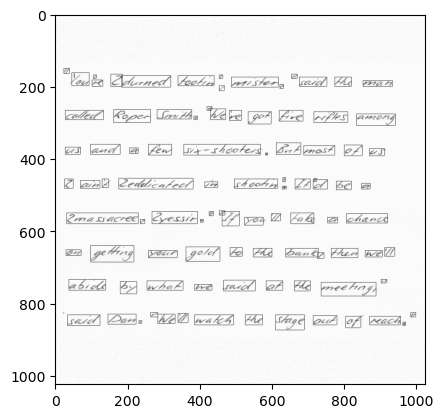

True

In [16]:
# 将图片二值化
_conv = torch.nn.Conv2d(1, 1, 3, padding=1, bias=False)
_conv.weight.data = torch.tensor([[[[0.3, 1, 0.3], [1, 3, 1], [0.3, 1, 0.3]]]], dtype=torch.float32)
def non_maximum_suppression(img, lower_bound=150, upper_bound=200):
    lower_bound = 1 - lower_bound / 255
    upper_bound = 1 - upper_bound / 255
    # 将图片变成0-1之间，并且黑白颠倒
    img = 1 - img / 255
    # 创建一个副本，用于存储结果
    new_img = torch.zeros_like(img)
    # 如果图片像素超过upper/lower bound，就直接设置为1/0
    indices = torch.where(img > lower_bound)
    new_img[indices] = 1
    indices = torch.where(img < upper_bound)
    new_img[indices] = 0
    # 对剩下的像素进行卷积，如果周围有很多像素是1，那么就设置为1
    for _ in range(10):
        temp = _conv(new_img.unsqueeze(0)).squeeze(0)
        indices = torch.where(temp >= 1.5)
        new_img[indices] = 1
    return new_img

# 找到连通的像素
def find_connected_pixels(img: torch.Tensor, finded_img: torch.Tensor, same_group: list, x, y):
    """
    args:
        img: 原始图片
        finded_img: 已经找到的像素图片，找到了标记为1，否则为0
        same_group: 相同的区域的像素，[(x1, y1), (x2, y2), ...]
        x: x坐标
        y: y坐标
    """
    # 如果坐标越界，直接返回
    if x < 0 or y < 0 or x >= img.shape[1] or y >= img.shape[2]:
        return
    # 如果已经找到了，直接返回
    if finded_img[x, y] == 1:
        return
    # 如果不是白色（笔画），直接返回
    if img[0, x, y] != 1:
        return
    # 标记为已找到
    finded_img[x, y] = 1
    # 添加到相同区域
    same_group.append((x, y))
    # 递归查找周围的像素
    find_connected_pixels(img, finded_img, same_group, x-1, y)
    find_connected_pixels(img, finded_img, same_group, x+1, y)
    find_connected_pixels(img, finded_img, same_group, x, y-1)
    find_connected_pixels(img, finded_img, same_group, x, y+1)

def find_all_connected_pixels(img: torch.Tensor):
    """
    args:
        img: 原始图片
    return:
        所有的相同区域的像素，[[(x1, y1), (x2, y2), ...], [(x1, y1), (x2, y2), ...], ...]
    """
    import sys
    sys.setrecursionlimit(1000000)
    # 创建一个副本，用于存储结果
    finded_img = torch.zeros(img.shape[1:], dtype=torch.uint8)
    # 所有的相同区域的像素
    all_same_group = []
    # 遍历所有像素
    for x in range(img.shape[1]):
        for y in range(img.shape[2]):
            # 如果已经找到了，直接返回
            if finded_img[x, y] == 1:
                continue
            # 如果不是白色（笔画），直接返回
            if img[0, x, y] != 1:
                continue
            # 新的相同区域
            same_group = []
            # 查找相同区域的像素
            find_connected_pixels(img, finded_img, same_group, x, y)
            # 添加到所有相同区域
            all_same_group.append(same_group)
    # 如果有的点太小，则删除
    all_same_group = [x for x in all_same_group if len(x) > 25]
    return all_same_group

# 对于每个相同区域，找到最小的矩形
def find_min_rectangle(all_same_group, bias=1):
    """
    args:
        all_same_group: 所有的相同区域的像素，[[(x1, y1), (x2, y2), ...], [(x1, y1), (x2, y2), ...], ...]
        bias: 为了更加精确，将矩形缩小一点
    return:
        所有的矩形，[(x1, y1, x2, y2), (x1, y1, x2, y2), ...]
    """
    rectangles = []
    for same_group in all_same_group:
        x1 = min([x for x, y in same_group]) + bias
        y1 = min([y for x, y in same_group]) + bias
        x2 = max([x for x, y in same_group]) - bias
        y2 = max([y for x, y in same_group]) - bias
        if x1 >= x2 or y1 >= y2:
            continue
        rectangles.append((x1, y1, x2, y2))
    
    # 如果有一个矩形包含另一个矩形，就删除
    for i in range(len(rectangles)):
        for j in range(i+1, len(rectangles)):
            if rectangles[i] is None or rectangles[j] is None:
                continue
            x1, y1, x2, y2 = rectangles[i]
            x3, y3, x4, y4 = rectangles[j]
            if x1 <= x3 and y1 <= y3 and x2 >= x4 and y2 >= y4:
                rectangles[j] = None
            if x1 >= x3 and y1 >= y3 and x2 <= x4 and y2 <= y4:
                rectangles[i] = None
    rectangles = [x for x in rectangles if x is not None]
    return rectangles

def ultimate(img: torch.Tensor):
    img = img.clone()
    img = non_maximum_suppression(img)
    img = img[:, ::2, ::2]
    all_same_group = find_all_connected_pixels(img)
    img = dataset[index][0].clone()
    rectangles = find_min_rectangle(all_same_group)
    rectangles = [[x1*2, y1*2, x2*2, y2*2] for x1, y1, x2, y2 in rectangles]
    return rectangles

index = random.randint(0, len(dataset)-1)
print("index:", index)
img = dataset[index][0].clone()

# # 将像素从暗到亮排序
# t0 = time.time()
# temp = img.detach().cpu().numpy().reshape(-1)
# temp = np.sort(temp)
# t1 = time.time()
# print("sort time:", t1-t0)
# # 找到阈值
# lower_bound = temp[int(len(temp) * 0.01)]
# upper_bound = temp[int(len(temp) * 0.1)]
# print("lower_bound:", lower_bound, "upper_bound:", upper_bound)
# t2 = time.time()
# print("find bound time:", t2-t1)

# show_img(img)
# img = non_maximum_suppression(img)
# show_img(img)
# # 将图片缩小以便于计算
# img = img[:, ::2, ::2]
# all_same_group = find_all_connected_pixels(img)
# t3 = time.time()
# print("find connected pixels time:", t3-t2)

# # 画出来
# img = dataset[index][0].clone()
# for rect in find_min_rectangle(all_same_group):
#     if rect is None:
#         continue
#     x1, y1, x2, y2 = rect
#     x1, y1, x2, y2 = x1*2, y1*2, x2*2, y2*2
#     img[0, x1:x2, y1] = 0
#     img[0, x1:x2, y2] = 0
#     img[0, x1, y1:y2] = 0
#     img[0, x2, y1:y2] = 0
# t4 = time.time()
# print("draw rectangle time:", t4-t3)

rectangles = ultimate(img)
for rect in rectangles:
    x1, y1, x2, y2 = rect
    img[0, x1, y1:y2] = 0
    img[0, x2, y1:y2] = 0
    img[0, x1:x2, y1] = 0
    img[0, x1:x2, y2] = 0

show_img(img)
# 把image保存下来
cv2.imwrite('test.png', img[0].numpy())